# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-10-01 07:27:30.485263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 07:27:31.301683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 35
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2222445
Valid Tokens:  243937
Test Tokens:  279249
Total number of tokens: 2745631


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 33264


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:

train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)


# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, _ = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, _ = self.rnn2(output)
    output = self.dropout2(output)
    
    output, _ = self.rnn3(output)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output

# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
model = model.to(device)

loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model

Trainable Parameters: 39.309264



H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 2540/2540 [05:59<00:00,  7.06batch/s, loss=6.06, perplexity=633]    


Valid: Loss = 5.183 Perplexity= 188.8, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 2540/2540 [06:03<00:00,  7.00batch/s, loss=5.5, perplexity=256] 


Valid: Loss = 4.971 Perplexity= 152.3, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 2540/2540 [06:06<00:00,  6.93batch/s, loss=5.29, perplexity=207]


Valid: Loss = 4.854 Perplexity= 135.1, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 2540/2540 [06:05<00:00,  6.95batch/s, loss=5.14, perplexity=178]


Valid: Loss = 4.778 Perplexity= 125.3, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 2540/2540 [06:05<00:00,  6.95batch/s, loss=5.03, perplexity=159]


Valid: Loss = 4.729 Perplexity= 119.5, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 2540/2540 [06:05<00:00,  6.96batch/s, loss=4.93, perplexity=145]


Valid: Loss = 4.7 Perplexity= 116.0, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 2540/2540 [06:05<00:00,  6.95batch/s, loss=4.86, perplexity=135]


Valid: Loss = 4.677 Perplexity= 113.4, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 2540/2540 [05:38<00:00,  7.50batch/s, loss=4.79, perplexity=126]


Valid: Loss = 4.658 Perplexity= 111.3, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.73, perplexity=119]


Valid: Loss = 4.649 Perplexity= 110.4, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.67, perplexity=112]


Valid: Loss = 4.631 Perplexity= 108.5, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 2540/2540 [05:25<00:00,  7.80batch/s, loss=4.62, perplexity=107]


Valid: Loss = 4.607 Perplexity= 105.9, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.58, perplexity=102]


Valid: Loss = 4.613 Perplexity= 106.6, LR = 0.5



Epoch 12: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.47, perplexity=92.2]


Valid: Loss = 4.565 Perplexity= 101.7, LR = 0.25
Model Saved!



Epoch 13: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.42, perplexity=87.3]


Valid: Loss = 4.554 Perplexity= 100.6, LR = 0.25
Model Saved!



Epoch 14: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.38, perplexity=84.3]


Valid: Loss = 4.548 Perplexity= 100.0, LR = 0.25
Model Saved!



Epoch 15: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.35, perplexity=81.8]


Valid: Loss = 4.55 Perplexity= 100.2, LR = 0.25



Epoch 16: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.3, perplexity=77.6] 


Valid: Loss = 4.508 Perplexity= 96.15, LR = 0.125
Model Saved!



Epoch 17: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.26, perplexity=74.9]


Valid: Loss = 4.502 Perplexity= 95.62, LR = 0.125
Model Saved!



Epoch 18: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.24, perplexity=73.1]


Valid: Loss = 4.498 Perplexity= 95.25, LR = 0.125
Model Saved!



Epoch 19: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.22, perplexity=71.6]


Valid: Loss = 4.497 Perplexity= 95.21, LR = 0.125
Model Saved!



Epoch 20: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.2, perplexity=70.1] 


Valid: Loss = 4.498 Perplexity= 95.34, LR = 0.125



Epoch 21: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.18, perplexity=68.7]


Valid: Loss = 4.472 Perplexity= 92.8, LR = 0.0625
Model Saved!



Epoch 22: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.16, perplexity=67.3]


Valid: Loss = 4.47 Perplexity= 92.63, LR = 0.0625
Model Saved!



Epoch 23: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.14, perplexity=66.3]


Valid: Loss = 4.466 Perplexity= 92.3, LR = 0.0625
Model Saved!



Epoch 24: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.13, perplexity=65.3]


Valid: Loss = 4.466 Perplexity= 92.27, LR = 0.0625
Model Saved!



Epoch 25: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.11, perplexity=64.5]


Valid: Loss = 4.463 Perplexity= 92.06, LR = 0.0625
Model Saved!



Epoch 26: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.1, perplexity=63.7] 


Valid: Loss = 4.456 Perplexity= 91.41, LR = 0.0625
Model Saved!



Epoch 27: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.09, perplexity=63]  


Valid: Loss = 4.458 Perplexity= 91.56, LR = 0.0625



Epoch 28: 100%|██████████| 2540/2540 [05:25<00:00,  7.81batch/s, loss=4.08, perplexity=62.6]


Valid: Loss = 4.429 Perplexity= 88.91, LR = 0.03125
Model Saved!



Epoch 29: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.07, perplexity=61.9]


Valid: Loss = 4.424 Perplexity= 88.56, LR = 0.03125
Model Saved!



Epoch 30: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.06, perplexity=61.4]


Valid: Loss = 4.423 Perplexity= 88.4, LR = 0.03125
Model Saved!



Epoch 31: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.06, perplexity=60.8]


Valid: Loss = 4.422 Perplexity= 88.36, LR = 0.03125
Model Saved!



Epoch 32: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.05, perplexity=60.3]


Valid: Loss = 4.424 Perplexity= 88.51, LR = 0.03125



Epoch 33: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.05, perplexity=60.8]


Valid: Loss = 4.402 Perplexity= 86.54, LR = 0.015625
Model Saved!



Epoch 34: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.05, perplexity=60.4]


Valid: Loss = 4.399 Perplexity= 86.22, LR = 0.015625
Model Saved!



Epoch 35: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.04, perplexity=60.1]


Valid: Loss = 4.397 Perplexity= 86.08, LR = 0.015625
Model Saved!



Epoch 36: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.04, perplexity=59.8]


Valid: Loss = 4.395 Perplexity= 85.88, LR = 0.015625
Model Saved!



Epoch 37: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.03, perplexity=59.5]


Valid: Loss = 4.395 Perplexity= 85.94, LR = 0.015625



Epoch 38: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.04, perplexity=60.2]


Valid: Loss = 4.376 Perplexity= 84.26, LR = 0.0078125
Model Saved!



Epoch 39: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.04, perplexity=60]  


Valid: Loss = 4.375 Perplexity= 84.1, LR = 0.0078125
Model Saved!



Epoch 40: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.04, perplexity=59.9]


Valid: Loss = 4.373 Perplexity= 84.01, LR = 0.0078125
Model Saved!



Epoch 41: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.04, perplexity=59.7]


Valid: Loss = 4.373 Perplexity= 83.95, LR = 0.0078125
Model Saved!



Epoch 42: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.03, perplexity=59.6]


Valid: Loss = 4.372 Perplexity= 83.88, LR = 0.0078125
Model Saved!



Epoch 43: 100%|██████████| 2540/2540 [05:23<00:00,  7.86batch/s, loss=4.03, perplexity=59.3]


Valid: Loss = 4.372 Perplexity= 83.87, LR = 0.0078125
Model Saved!



Epoch 44: 100%|██████████| 2540/2540 [05:23<00:00,  7.86batch/s, loss=4.03, perplexity=59.3]


Valid: Loss = 4.37 Perplexity= 83.76, LR = 0.0078125
Model Saved!



Epoch 45: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.03, perplexity=59.2]


Valid: Loss = 4.37 Perplexity= 83.74, LR = 0.0078125
Model Saved!



Epoch 46: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=59]  


Valid: Loss = 4.369 Perplexity= 83.65, LR = 0.0078125
Model Saved!



Epoch 47: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.9]


Valid: Loss = 4.369 Perplexity= 83.64, LR = 0.0078125
Model Saved!



Epoch 48: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.368 Perplexity= 83.61, LR = 0.0078125
Model Saved!



Epoch 49: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.368 Perplexity= 83.6, LR = 0.0078125
Model Saved!



Epoch 50: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.01, perplexity=58.4]


Valid: Loss = 4.368 Perplexity= 83.63, LR = 0.0078125



Epoch 51: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=59]  


Valid: Loss = 4.357 Perplexity= 82.67, LR = 0.00390625
Model Saved!



Epoch 52: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.03, perplexity=59.2]


Valid: Loss = 4.356 Perplexity= 82.54, LR = 0.00390625
Model Saved!



Epoch 53: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.03, perplexity=59.7]


Valid: Loss = 4.353 Perplexity= 82.29, LR = 0.00390625
Model Saved!



Epoch 54: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.03, perplexity=59.6]


Valid: Loss = 4.352 Perplexity= 82.23, LR = 0.00390625
Model Saved!



Epoch 55: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.03, perplexity=59.3]


Valid: Loss = 4.351 Perplexity= 82.17, LR = 0.00390625
Model Saved!



Epoch 56: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.03, perplexity=59.1]


Valid: Loss = 4.351 Perplexity= 82.13, LR = 0.00390625
Model Saved!



Epoch 57: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.02, perplexity=59]  


Valid: Loss = 4.351 Perplexity= 82.14, LR = 0.00390625



Epoch 58: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.03, perplexity=59.4]


Valid: Loss = 4.345 Perplexity= 81.67, LR = 0.001953125
Model Saved!



Epoch 59: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.03, perplexity=59.3]


Valid: Loss = 4.345 Perplexity= 81.63, LR = 0.001953125
Model Saved!



Epoch 60: 100%|██████████| 2540/2540 [05:25<00:00,  7.82batch/s, loss=4.03, perplexity=59.2]


Valid: Loss = 4.345 Perplexity= 81.6, LR = 0.001953125
Model Saved!



Epoch 61: 100%|██████████| 2540/2540 [05:25<00:00,  7.82batch/s, loss=4.02, perplexity=59.1]


Valid: Loss = 4.345 Perplexity= 81.6, LR = 0.001953125
Model Saved!



Epoch 62: 100%|██████████| 2540/2540 [05:25<00:00,  7.82batch/s, loss=4.02, perplexity=59]  


Valid: Loss = 4.344 Perplexity= 81.57, LR = 0.001953125
Model Saved!



Epoch 63: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.02, perplexity=58.9]


Valid: Loss = 4.344 Perplexity= 81.56, LR = 0.001953125
Model Saved!



Epoch 64: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.9]


Valid: Loss = 4.344 Perplexity= 81.53, LR = 0.001953125
Model Saved!



Epoch 65: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.9]


Valid: Loss = 4.343 Perplexity= 81.51, LR = 0.001953125
Model Saved!



Epoch 66: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.343 Perplexity= 81.51, LR = 0.001953125



Epoch 67: 100%|██████████| 2540/2540 [05:23<00:00,  7.86batch/s, loss=4.02, perplexity=59]  


Valid: Loss = 4.341 Perplexity= 81.29, LR = 0.0009765625
Model Saved!



Epoch 68: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=59.1]


Valid: Loss = 4.341 Perplexity= 81.27, LR = 0.0009765625
Model Saved!



Epoch 69: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=59]  


Valid: Loss = 4.34 Perplexity= 81.2, LR = 0.0009765625
Model Saved!



Epoch 70: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=59]  


Valid: Loss = 4.339 Perplexity= 81.18, LR = 0.0009765625
Model Saved!



Epoch 71: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=59]  


Valid: Loss = 4.339 Perplexity= 81.16, LR = 0.0009765625
Model Saved!



Epoch 72: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=59]  


Valid: Loss = 4.339 Perplexity= 81.11, LR = 0.0009765625
Model Saved!



Epoch 73: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.9]


Valid: Loss = 4.338 Perplexity= 81.1, LR = 0.0009765625
Model Saved!



Epoch 74: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.339 Perplexity= 81.1, LR = 0.0009765625



Epoch 75: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.9]


Valid: Loss = 4.337 Perplexity= 80.97, LR = 0.00048828125
Model Saved!



Epoch 76: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.337 Perplexity= 80.95, LR = 0.00048828125
Model Saved!



Epoch 77: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.336 Perplexity= 80.94, LR = 0.00048828125
Model Saved!



Epoch 78: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.336 Perplexity= 80.92, LR = 0.00048828125
Model Saved!



Epoch 79: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.336 Perplexity= 80.91, LR = 0.00048828125
Model Saved!



Epoch 80: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.336 Perplexity= 80.91, LR = 0.00048828125



Epoch 81: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.336 Perplexity= 80.86, LR = 0.000244140625
Model Saved!



Epoch 82: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.335 Perplexity= 80.84, LR = 0.000244140625
Model Saved!



Epoch 83: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.335 Perplexity= 80.84, LR = 0.000244140625



Epoch 84: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.335 Perplexity= 80.83, LR = 0.0001220703125
Model Saved!



Epoch 85: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.335 Perplexity= 80.81, LR = 0.0001220703125
Model Saved!



Epoch 86: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.335 Perplexity= 80.8, LR = 0.0001220703125
Model Saved!



Epoch 87: 100%|██████████| 2540/2540 [05:23<00:00,  7.86batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.335 Perplexity= 80.8, LR = 0.0001220703125
Model Saved!



Epoch 88: 100%|██████████| 2540/2540 [05:23<00:00,  7.86batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.335 Perplexity= 80.79, LR = 0.0001220703125
Model Saved!



Epoch 89: 100%|██████████| 2540/2540 [05:23<00:00,  7.86batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.335 Perplexity= 80.79, LR = 0.0001220703125
Model Saved!



Epoch 90: 100%|██████████| 2540/2540 [05:23<00:00,  7.86batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.335 Perplexity= 80.78, LR = 0.0001220703125
Model Saved!



Epoch 91: 100%|██████████| 2540/2540 [05:23<00:00,  7.86batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.335 Perplexity= 80.78, LR = 0.0001220703125



Epoch 92: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.335 Perplexity= 80.78, LR = 6.103515625e-05
Model Saved!



Epoch 93: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.335 Perplexity= 80.78, LR = 6.103515625e-05
Model Saved!



Epoch 94: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.335 Perplexity= 80.77, LR = 6.103515625e-05
Model Saved!



Epoch 95: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.77, LR = 6.103515625e-05
Model Saved!



Epoch 96: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.77, LR = 6.103515625e-05
Model Saved!



Epoch 97: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.77, LR = 6.103515625e-05
Model Saved!



Epoch 98: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.77, LR = 6.103515625e-05
Model Saved!



Epoch 99: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.77, LR = 6.103515625e-05
Model Saved!



Epoch 100: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.77, LR = 6.103515625e-05
Model Saved!



Epoch 101: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.77, LR = 6.103515625e-05



Epoch 102: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.77, LR = 3.0517578125e-05
Model Saved!



Epoch 103: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.77, LR = 3.0517578125e-05
Model Saved!



Epoch 104: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 3.0517578125e-05
Model Saved!



Epoch 105: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 3.0517578125e-05
Model Saved!



Epoch 106: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 3.0517578125e-05
Model Saved!



Epoch 107: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 3.0517578125e-05



Epoch 108: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 109: 100%|██████████| 2540/2540 [05:24<00:00,  7.82batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 110: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 111: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 112: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 113: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 114: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 115: 100%|██████████| 2540/2540 [05:24<00:00,  7.83batch/s, loss=4.01, perplexity=58.5]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 116: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 117: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 118: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 119: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 120: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 121: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05
Model Saved!



Epoch 122: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.52587890625e-05



Epoch 123: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 7.62939453125e-06
Model Saved!



Epoch 124: 100%|██████████| 2540/2540 [05:23<00:00,  7.85batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 7.62939453125e-06



Epoch 125: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 3.814697265625e-06



Epoch 126: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.9073486328125e-06
Model Saved!



Epoch 127: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.9073486328125e-06



Epoch 128: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 9.5367431640625e-07



Epoch 129: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 4.76837158203125e-07



Epoch 130: 100%|██████████| 2540/2540 [05:23<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 2.384185791015625e-07



Epoch 131: 100%|██████████| 2540/2540 [05:24<00:00,  7.84batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.334 Perplexity= 80.76, LR = 1.1920928955078125e-07
LR_DEC==3 , Finished


## Learning Curve

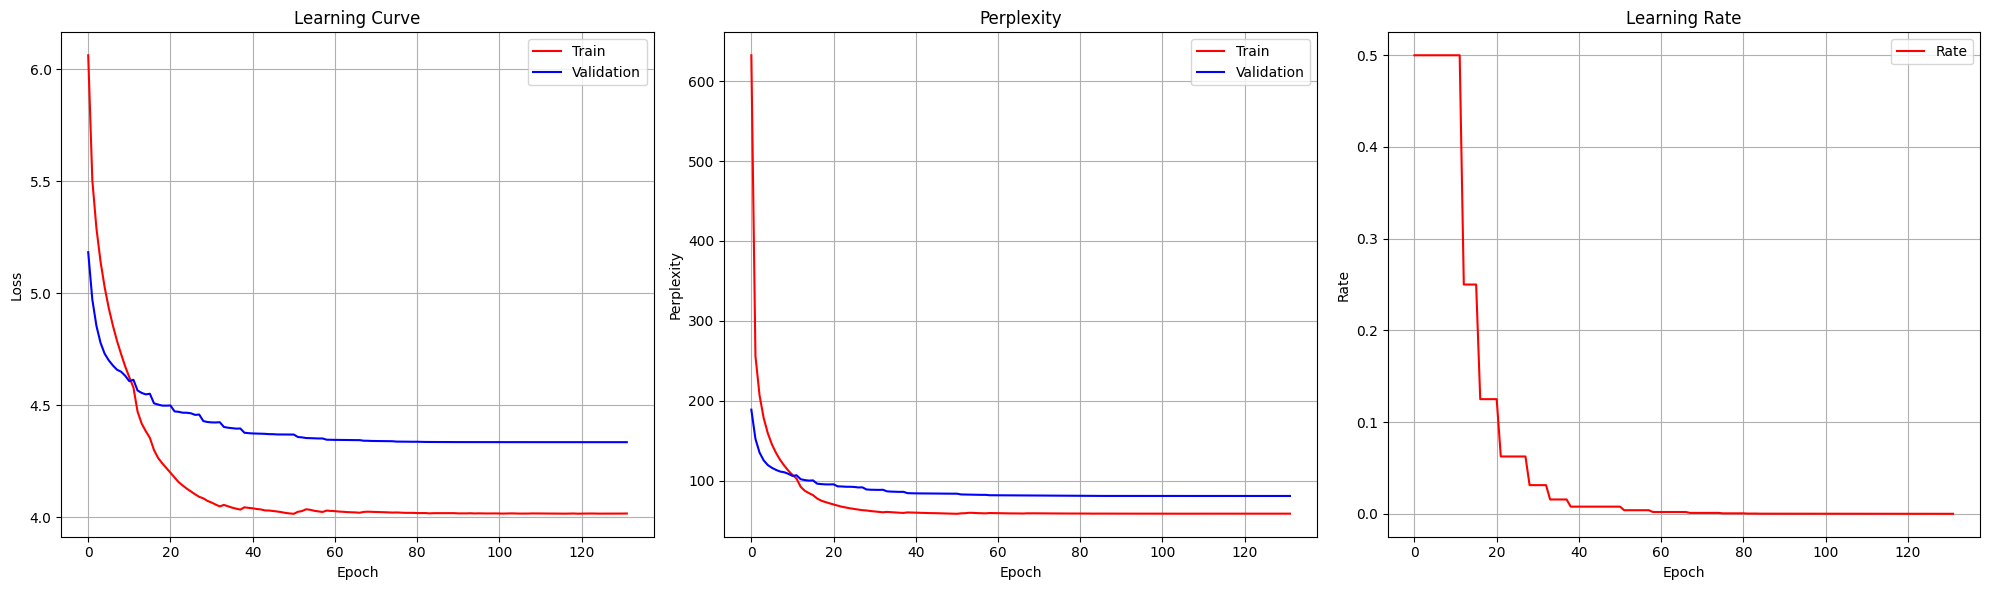

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
#LanguageModel = H_LSTM

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 4.334 , Perplexity = 80.76
Test: Loss = 4.218 , Perplexity = 73.96


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

In [22]:
num_trainable_params(model)

39.309264

In [23]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie was an important part of the television series &apos; Hero &apos; , and that the &quot; &lt; unk &gt; &apos; s &lt; unk &gt; &quot; was the only one to be a &lt; unk &gt; from the &lt; unk &gt; .
